In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydaptivefiltering as pdf

In [2]:
# --- 1. CONFIGURAÇÃO DO CENÁRIO ---
np.random.seed(123)
n_samples = 1000
filter_order = 5  # 6 taps

# Entrada complexa (Ruído branco complexo)
x = (np.random.randn(n_samples) + 1j*np.random.randn(n_samples)) / np.sqrt(2)

# Planta Desconhecida (Complexa)
w_true = np.array([0.5+0.2j, -0.4+0.5j, 0.1-0.1j, 0.2, -0.1+0.1j, 0.05j])

# Geração do sinal desejado d[k] = w_true^H * x[k] + ruído
d = np.zeros(n_samples, dtype=complex)
for k in range(len(w_true), n_samples):
    regressor = x[k : k - len(w_true) : -1]
    d[k] = np.vdot(w_true, regressor) + 0.05 * (np.random.randn() + 1j*np.random.randn())

# --- 2. EXECUÇÃO DO FILTRO RLS ---
# delta: inicialização da matriz S_d (costuma ser um valor pequeno, ex: 0.01)
# forgetting_factor: fator de esquecimento (lambda) (próximo a 1 para sinais estacionários)
filt_rls = pdf.RLS(
    filter_order=filter_order,
    delta=0.01,
    forgetting_factor=0.99
)

result = filt_rls.optimize(x, d, verbose=True, return_internal_states=True)

[RLS] Completed in 19.003 ms


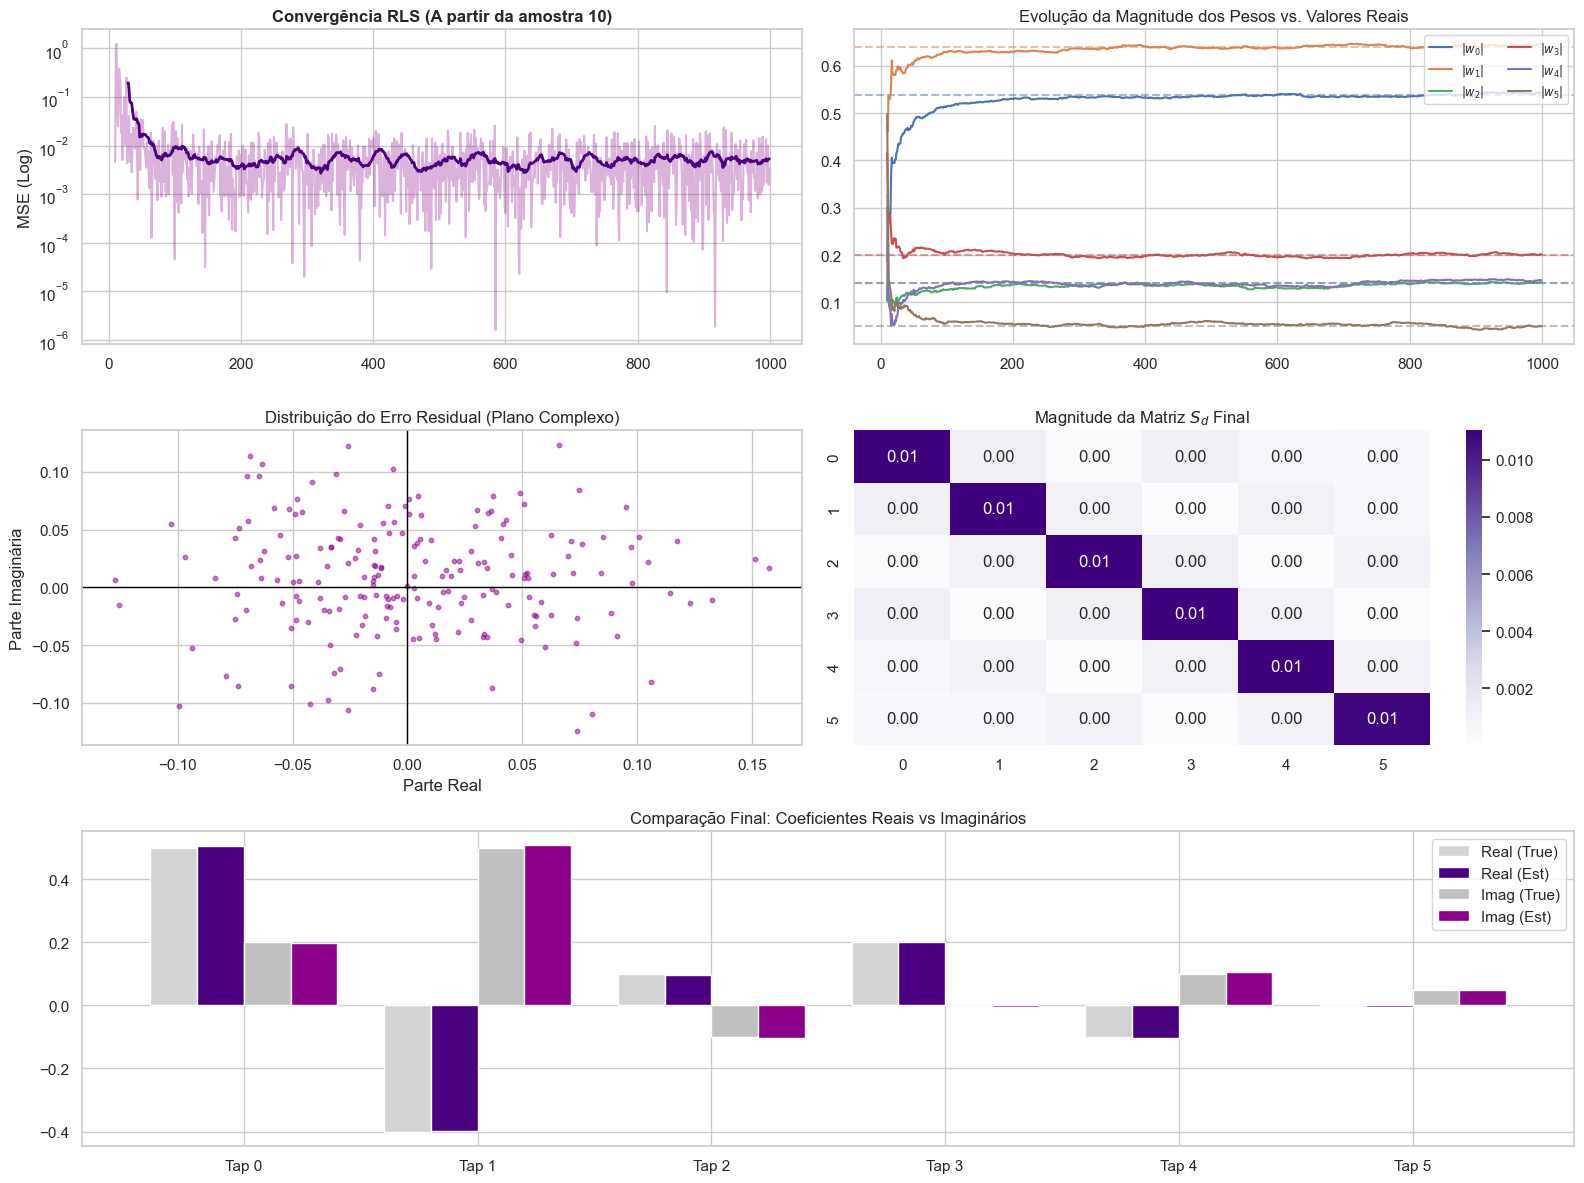

In [3]:
# --- 3. DASHBOARD DE DIAGNÓSTICO (SEM TRANSIENTE INICIAL) ---
def plot_rls_dashboard(result, w_true, offset=10):
    sns.set_theme(style="whitegrid")
    
    # Fatiamento para remover as primeiras 10 amostras
    mse = result.mse()[offset:]
    t = np.arange(len(result.mse()))[offset:]
    
    # Coeficientes: pegamos a magnitude para visualizar a convergência
    coeffs = np.abs(np.array(result.coefficients)[1:])[offset:]
    w_true_mag = np.abs(w_true)

    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2)

    # A. Curva de Aprendizado (MSE)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.semilogy(t, mse, color='darkmagenta', alpha=0.3)
    ax1.semilogy(t, pd.Series(mse).rolling(20).mean(), color='indigo', lw=2)
    ax1.set_title(f"Convergência RLS (A partir da amostra {offset})", fontweight='bold')
    ax1.set_ylabel("MSE (Log)")

    # B. Evolução da Magnitude dos Pesos
    ax2 = fig.add_subplot(gs[0, 1])
    for i in range(coeffs.shape[1]):
        line, = ax2.plot(t, coeffs[:, i], label=f'$|w_{{{i}}}|$')
        ax2.axhline(y=w_true_mag[i], color=line.get_color(), linestyle='--', alpha=0.5)
    ax2.set_title("Evolução da Magnitude dos Pesos vs. Valores Reais")
    ax2.legend(loc='upper right', fontsize='x-small', ncol=2)

    # C. Erro Complexo (Real vs Imag) - Últimas 200 amostras
    ax3 = fig.add_subplot(gs[1, 0])
    last_err = result.errors[-200:]
    ax3.scatter(last_err.real, last_err.imag, alpha=0.5, color='darkmagenta', s=10)
    ax3.axhline(0, color='black', lw=1)
    ax3.axvline(0, color='black', lw=1)
    ax3.set_title("Distribuição do Erro Residual (Plano Complexo)")
    ax3.set_xlabel("Parte Real")
    ax3.set_ylabel("Parte Imaginária")

    # D. Matriz de Correlação Inversa S_d (Magnitude)
    ax4 = fig.add_subplot(gs[1, 1])
    sns.heatmap(np.abs(result.extra['S_d_last']), annot=True, fmt=".2f", cmap="Purples", ax=ax4)
    ax4.set_title("Magnitude da Matriz $S_d$ Final")

    # E. Comparação Final de Pesos (Parte Real e Imaginária)
    ax5 = fig.add_subplot(gs[2, :])
    w_final = result.coefficients[-1]
    x_labels = [f'Tap {i}' for i in range(len(w_true))]
    x_pos = np.arange(len(x_labels))
    
    ax5.bar(x_pos - 0.2, w_true.real, 0.2, label='Real (True)', color='lightgray')
    ax5.bar(x_pos, w_final.real, 0.2, label='Real (Est)', color='indigo')
    ax5.bar(x_pos + 0.2, w_true.imag, 0.2, label='Imag (True)', color='silver')
    ax5.bar(x_pos + 0.4, w_final.imag, 0.2, label='Imag (Est)', color='darkmagenta')
    ax5.set_xticks(x_pos + 0.1)
    ax5.set_xticklabels(x_labels)
    ax5.set_title("Comparação Final: Coeficientes Reais vs Imaginários")
    ax5.legend()

    plt.tight_layout()
    plt.show()

plot_rls_dashboard(result, w_true, offset=10)